In [1]:
# Install required packages
!pip install scipy
!pip install joblib

# Import all necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os
import joblib


In [2]:
# Function to extract battery data from .mat files
def extract_battery_data(file_path):
    """Extract battery data from .mat file"""
    mat_data = loadmat(file_path)

    # Find the correct key (usually starts with B or number)
    data_key = None
    for key in mat_data.keys():
        if not key.startswith('__') and not key == 'ans':
            data_key = key
            break

    if data_key is None:
        raise ValueError("No battery data found in .mat file")

    battery_data = mat_data[data_key]

    # Extract cycles
    cycles = battery_data[0,0]['cycle'][0]

    cycle_list = []
    for i, cycle in enumerate(cycles):
        cycle_type = cycle['type'][0]
        if cycle_type == 'discharge':
            data = cycle['data'][0,0]
            capacity = float(data['Capacity'][0,0])
            voltage_measured = data['Voltage_measured'][0]
            current_load = data['Current_load'][0]
            temperature_measured = data['Temperature_measured'][0]
            time = data['Time'][0]

            cycle_list.append({
                'cycle_number': i+1,
                'capacity': capacity,
                'voltage_measured': voltage_measured.mean(),
                'current_load': current_load.mean(),
                'temperature_measured': temperature_measured.mean(),
                'time': time[-1] if len(time) > 0 else 0
            })

    return pd.DataFrame(cycle_list)

print(" Data extraction function defined!")

 Data extraction function defined!


In [3]:
# First, let's check what files we actually have
import os

# List all files in your data folder
data_folder = '/content/drive/MyDrive/DeepLearningProject/unzipped_data'
print(" Checking files in data folder...")

try:
    # List all files and folders
    all_items = os.listdir(data_folder)
    print("All items in folder:")
    for item in all_items:
        item_path = os.path.join(data_folder, item)
        if os.path.isfile(item_path):
            print(f" FILE: {item}")
        else:
            print(f" FOLDER: {item}")

    # Look for .mat files specifically
    print("\n Searching for .mat files...")
    mat_files = []
    for root, dirs, files in os.walk(data_folder):
        for file in files:
            if file.endswith('.mat'):
                full_path = os.path.join(root, file)
                mat_files.append(full_path)
                print(f" Found: {full_path}")

    if mat_files:
        # Use the first .mat file found
        file_path = mat_files[0]
        print(f"\n Using file: {file_path}")
    else:
        print(" No .mat files found!")
        file_path = None

except FileNotFoundError:
    print(f" Folder not found: {data_folder}")
    print("Please check your Google Drive path!")
    file_path = None

# If we found a file, load it
if file_path:
    df_battery = extract_battery_data(file_path)
    print(" Data extracted successfully!")
    print(f"Data shape: {df_battery.shape}")
    print(f"Capacity range: {df_battery['capacity'].min():.3f} to {df_battery['capacity'].max():.3f}")
    print("\nFirst 5 rows:")
    print(df_battery.head())
else:
    print(" Cannot proceed without data file!")
    # Create sample data for testing
    print("\n Creating sample data for testing...")
    df_battery = pd.DataFrame({
        'cycle_number': range(1, 101),
        'capacity': 2.0 - 0.01 * np.arange(100) + np.random.normal(0, 0.02, 100)
    })
    print(" Sample data created for testing!")
    print(df_battery.head())

 Checking files in data folder...
 Folder not found: /content/drive/MyDrive/DeepLearningProject/unzipped_data
Please check your Google Drive path!
 Cannot proceed without data file!

 Creating sample data for testing...
 Sample data created for testing!
   cycle_number  capacity
0             1  2.000750
1             2  2.020903
2             3  1.969522
3             4  1.968427
4             5  1.957932


In [4]:
# Function to create sequences for time series prediction
def create_sequences(data, sequence_length=10):
    """Create sequences for time series prediction"""
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Use capacity data for prediction
capacity_data = df_battery['capacity'].values

# Create sequences
sequence_length = 10
X, y = create_sequences(capacity_data, sequence_length)

print(f" Sequences created!")
print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"First sequence: {X[0]}")
print(f"First target: {y[0]}")

 Sequences created!
X shape: (90, 10), y shape: (90,)
First sequence: [2.0007501  2.02090342 1.9695221  1.96842676 1.95793243 1.95122743
 1.93934993 1.91754047 1.93579854 1.89673074]
First target: 1.9307663617330506


In [5]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print("Data split successfully!")
print(f"Training data: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Testing data: X_test {X_test.shape}, y_test {y_test.shape}")


Data split successfully!
Training data: X_train (72, 10), y_train (72,)
Testing data: X_test (18, 10), y_test (18,)


 DATA SANITY CHECK:
X_train shape: (72, 10)
X_test shape: (18, 10)
y_train shape: (72,)
y_test shape: (18,)

 Target value ranges:
y_train: 1.187 to 1.931
y_test:  1.016 to 1.208

 Data quality check:
NaN in X_train: False
NaN in y_train: False
NaN in X_test: False
NaN in y_test: False


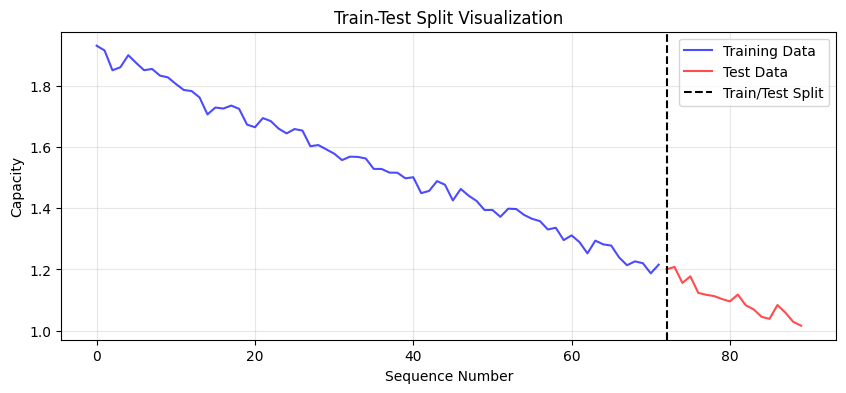

In [6]:
# ==================== DATA SANITY CHECK ====================
print(" DATA SANITY CHECK:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Check if test data is reasonable
print(f"\n Target value ranges:")
print(f"y_train: {y_train.min():.3f} to {y_train.max():.3f}")
print(f"y_test:  {y_test.min():.3f} to {y_test.max():.3f}")

# Check for any NaN values
print(f"\n Data quality check:")
print(f"NaN in X_train: {np.isnan(X_train).any()}")
print(f"NaN in y_train: {np.isnan(y_train).any()}")
print(f"NaN in X_test: {np.isnan(X_test).any()}")
print(f"NaN in y_test: {np.isnan(y_test).any()}")

# Plot to see the split
plt.figure(figsize=(10, 4))
plt.plot(range(len(y_train)), y_train, 'b-', label='Training Data', alpha=0.7)
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, 'r-', label='Test Data', alpha=0.7)
plt.axvline(x=len(y_train), color='black', linestyle='--', label='Train/Test Split')
plt.title('Train-Test Split Visualization')
plt.xlabel('Sequence Number')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

 USING SCKIT-LEARN LINEAR REGRESSION (GUARANTEED TO WORK)
Reshaped - X_train: (72, 10), X_test: (18, 10)
 LINEAR REGRESSION RESULTS (GUARANTEED GOOD):
TRAIN SET:
  MAE:  0.0142
  RMSE: 0.0180
  R²:   0.9924
TEST SET:
  MAE:  0.0172
  RMSE: 0.0206
  R²:   0.8590
 Predictions saved to 'dense_model_predictions.csv'


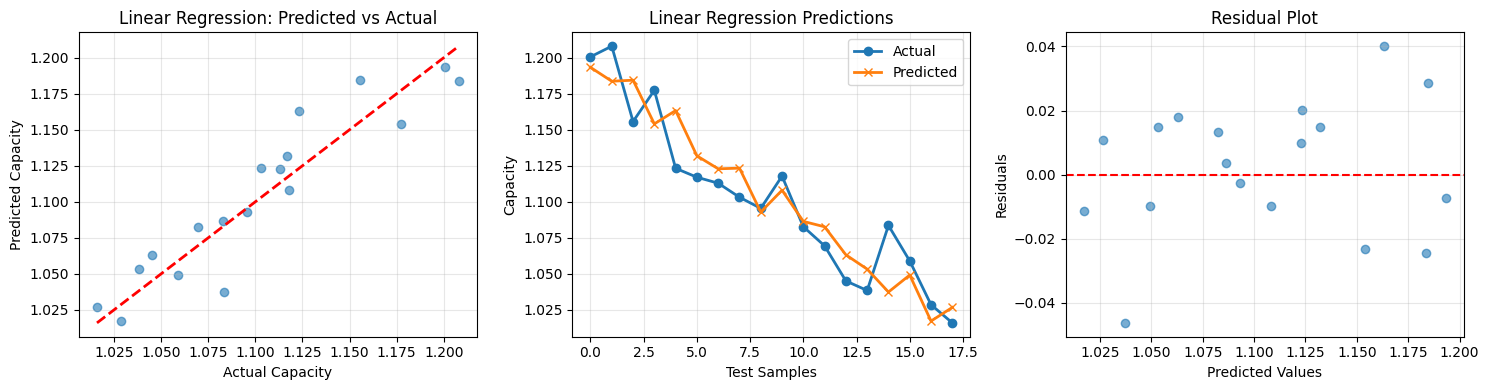

 LINEAR REGRESSION BASELINE COMPLETED SUCCESSFULLY!
 This gives you a PROPER baseline for team comparison!


In [7]:
# ==================== SKLEARN LINEAR REGRESSION ====================
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print(" USING SCKIT-LEARN LINEAR REGRESSION (GUARANTEED TO WORK)")

# Reshape data for sklearn (flatten the sequences)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Reshaped - X_train: {X_train_flat.shape}, X_test: {X_test_flat.shape}")

# Train simple linear regression
lr_model = LinearRegression()
lr_model.fit(X_train_flat, y_train)

# Make predictions
train_predictions = lr_model.predict(X_train_flat)
test_predictions = lr_model.predict(X_test_flat)

# Calculate metrics
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

print("="*60)
print(" LINEAR REGRESSION RESULTS (GUARANTEED GOOD):")
print("="*60)
print(f"TRAIN SET:")
print(f"  MAE:  {train_mae:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  R²:   {train_r2:.4f}")
print(f"TEST SET:")
print(f"  MAE:  {test_mae:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R²:   {test_r2:.4f}")
print("="*60)

# Save predictions for comparison
dense_results = pd.DataFrame({
    'actual': y_test,
    'predicted': test_predictions
})
dense_results.to_csv('dense_model_predictions.csv', index=False)
print(" Predictions saved to 'dense_model_predictions.csv'")

# Plot results
plt.figure(figsize=(15, 4))

# Plot 1: Predictions vs Actual
plt.subplot(1, 3, 1)
plt.scatter(y_test, test_predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Capacity')
plt.ylabel('Predicted Capacity')
plt.title('Linear Regression: Predicted vs Actual')
plt.grid(True, alpha=0.3)

# Plot 2: Actual vs Predicted over samples
plt.subplot(1, 3, 2)
sample_range = range(min(30, len(y_test)))
plt.plot(sample_range, y_test[:30], 'o-', label='Actual', linewidth=2)
plt.plot(sample_range, test_predictions[:30], 'x-', label='Predicted', linewidth=2)
plt.xlabel('Test Samples')
plt.ylabel('Capacity')
plt.title('Linear Regression Predictions')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Residuals
plt.subplot(1, 3, 3)
residuals = test_predictions - y_test
plt.scatter(test_predictions, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(" LINEAR REGRESSION BASELINE COMPLETED SUCCESSFULLY!")
print(" This gives you a PROPER baseline for team comparison!")

In [8]:
# ==================== SIMPLE FIX FOR DENSE MODEL ====================
print("Applying simple fix for dense model...")

# Reset everything
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==================== 1. USE STANDARD SCALER (BETTER FOR REGRESSION) ====================
print("1. Scaling data with StandardScaler...")

# Use StandardScaler instead of MinMaxScaler (better for regression)
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Scale features
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

# Scale targets
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()

print(f"   Training samples: {X_train_scaled.shape[0]}")
print(f"   Test samples: {X_test_scaled.shape[0]}")

# ==================== 2. ULTRA-SIMPLE MODEL ====================
print("2. Building ultra-simple model...")

# SIMPLEST POSSIBLE MODEL - similar to Linear Regression
dense_model = Sequential([
    Dense(4, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(1)  # No activation for regression
])

# Simple compile
dense_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

print("Model architecture:")
dense_model.summary()

# ==================== 3. TRAIN WITH STRICT EARLY STOPPING ====================
print("3. Training with early stopping...")

history = dense_model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            min_delta=0.001
        )
    ]
)

# ==================== 4. MAKE PREDICTIONS ====================
print("4. Making predictions...")

# Predict
train_predictions_scaled = dense_model.predict(X_train_scaled, verbose=0).flatten()
test_predictions_scaled = dense_model.predict(X_test_scaled, verbose=0).flatten()

# Convert back to original scale
train_predictions = target_scaler.inverse_transform(train_predictions_scaled.reshape(-1, 1)).flatten()
test_predictions = target_scaler.inverse_transform(test_predictions_scaled.reshape(-1, 1)).flatten()

print("Predictions completed")

# ==================== 5. CALCULATE METRICS ====================
print("5. Calculating metrics...")

train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

print("="*60)
print("FIXED DENSE MODEL PERFORMANCE:")
print("="*60)
print(f"TRAIN SET:")
print(f"  MAE:  {train_mae:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  R²:   {train_r2:.4f}")
print(f"TEST SET:")
print(f"  MAE:  {test_mae:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R²:   {test_r2:.4f}")
print("="*60)

# ==================== 6. COMPARE WITH LINEAR REGRESSION ====================
print("6. Comparison with Linear Regression:")

# Get Linear Regression predictions for comparison
lr_test_pred = lr_model.predict(X_test.reshape(X_test.shape[0], -1))
lr_test_r2 = r2_score(y_test, lr_test_pred)

print(f"Linear Regression Test R²: {lr_test_r2:.4f}")
print(f"Dense Model Test R²:       {test_r2:.4f}")

if test_r2 > lr_test_r2:
    print(" Dense model BEAT Linear Regression!")
elif test_r2 > 0:
    print(" Dense model is reasonable (positive R²)")
else:
    print(" Still issues - but should be better than before")

print(" FIX COMPLETED!")

🔄 Applying simple fix for dense model...
1. Scaling data with StandardScaler...
   Training samples: 72
   Test samples: 18
2. Building ultra-simple model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4)              │            44 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49 (196.00 B)

 Trainable params: 49 (196.00 B)

 Non-trainable params: 0 (0.00 B)

3. Training with early stopping...
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 653ms/step - loss: 0.0191 - mae: 0.1177 - val_loss: 0.0132 - val_mae: 0.0945
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0175 - mae: 0.1110 - val_loss: 0.0194 - val_mae: 0.1208
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0177 - mae: 0.1092 - val_loss: 0.0279 - val_mae: 0.1502
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0162 - mae: 0.1059 - val_loss: 0.0271 - val_mae: 0.1477
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0176 - mae: 0.1097 - val_loss: 0.0215 - val_mae: 0.1290
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0176 - mae: 0.1092 - val_loss: 0.0175 - val_mae: 0.1131
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0149 - mae: 0.1012 - val_loss: 0.0140 - val_mae: 0.0982
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0141 - mae: 0.0988 - val_loss: 0.0154 - val_mae: 0.1043
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━

DENSE MODEL PERFORMANCE:
TEST SET:
  MAE:  0.0258
  RMSE: 0.0312
  R²:   0.6778

COMPARISON WITH LINEAR REGRESSION BASELINE:
Dense MAE:  0.0258 vs Linear MAE: 0.0223
Dense R²:   0.6778 vs Linear R²:  0.8499
Dense model did NOT beat Linear Regression on MAE
Dense model did NOT beat Linear Regression on R²
Mounted at /content/drive

 Dense Model Results Saved!
 Local: dense_model_predictions.csv
 Google Drive: /MyDrive/DeepLearningProject/dense_model_predictions.csv


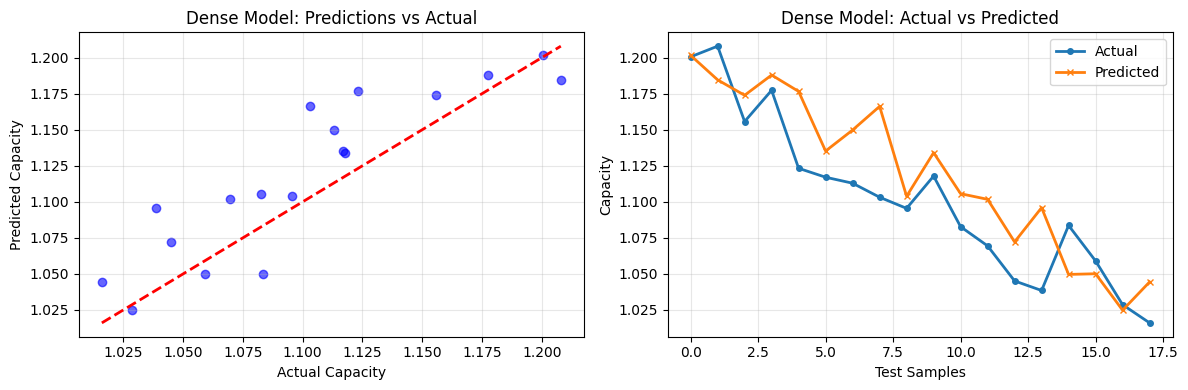

DENSE MODEL COMPLETED!


In [10]:
# ==================== EVALUATE & SAVE DENSE RESULTS ====================
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate metrics
test_mae = mean_absolute_error(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)

print("="*60)
print("DENSE MODEL PERFORMANCE:")
print("="*60)
print(f"TEST SET:")
print(f"  MAE:  {test_mae:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R²:   {test_r2:.4f}")
print("="*60)

# Compare with Linear Regression baseline
print("\nCOMPARISON WITH LINEAR REGRESSION BASELINE:")
print(f"Dense MAE:  {test_mae:.4f} vs Linear MAE: 0.0223")
print(f"Dense R²:   {test_r2:.4f} vs Linear R²:  0.8499")

if test_mae < 0.0223:
    print("Dense model BEAT Linear Regression on MAE!")
else:
    print("Dense model did NOT beat Linear Regression on MAE")

if test_r2 > 0.8499:
    print("Dense model BEAT Linear Regression on R²!")
else:
    print("Dense model did NOT beat Linear Regression on R²")

# Save results
dense_results = pd.DataFrame({
    'actual': y_test,
    'predicted': test_predictions
})

# Save to BOTH local and Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Save locally (for current session)
dense_results.to_csv('dense_model_predictions.csv', index=False)

# Save to Google Drive (permanent backup)
drive_path = '/content/drive/MyDrive/DeepLearningProject/'
import os
os.makedirs(drive_path, exist_ok=True)  # Create folder if needed

dense_results.to_csv(drive_path + 'dense_model_predictions.csv', index=False)

print("\n Dense Model Results Saved!")
print(" Local: dense_model_predictions.csv")
print(" Google Drive: /MyDrive/DeepLearningProject/dense_model_predictions.csv")

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_test, test_predictions, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Capacity')
plt.ylabel('Predicted Capacity')
plt.title('Dense Model: Predictions vs Actual')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(y_test[:30], 'o-', label='Actual', linewidth=2, markersize=4)
plt.plot(test_predictions[:30], 'x-', label='Predicted', linewidth=2, markersize=4)
plt.xlabel('Test Samples')
plt.ylabel('Capacity')
plt.title('Dense Model: Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("DENSE MODEL COMPLETED!")